### Cab-Driver Agent

In [1]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')
import os
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Nadam

# for plotting graphs
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [((0, 12, 1), (1, 4)), ((1, 12, 4), (1, 2)),
                  ((2, 14, 2), (2, 3)), ((3, 18, 5), (3, 4))]

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
def plot_tracked_values(states_tracks):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    for index, tracked_value in enumerate(tracked_values):
        xaxis = np.asarray(
            range(0, len(states_tracks[tracked_value[0]][tracked_value[1]])))
        plt.subplot(2, 2, index + 1)
        plt.plot(xaxis,
                 np.asarray(states_tracks[tracked_value[0]][tracked_value[1]]))
        plt.title("({},{},{})".format(tracked_value[0][0], tracked_value[0][1],
                                      tracked_value[0][2]) + "_" +
                  "({},{})".format(tracked_value[1][0], tracked_value[1][1]))
    plt.show()

In [7]:
class AgentParam:
    def __init__(self, params):
        self.learning_rate = params.get("learning_rate", 0.01)
        self.action_size = params["action_size"]
        self.state_size = params["state_size"]
        self.action_space = params["action_space"]
        self.epsilon_max = params.get("epsilon_max", 1.0)
        self.epsilon_min = params.get("epsilon_min", 0.0001)
        self.epsilon_decay = params.get("epsilon_decay", 0.0009)
        self.discount_factor = params.get("discount_factor", 0.95)
        self.batch_size = params.get("batch_size", 32)
        self.layers = params["layers"]

    def _print(self):
        attrs = vars(self)
        print("Agent Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            print(key, '->', value)
        print("********************************************************")

In [8]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon_max, epsilon_min, epsilon_decay):
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_epsilon(self, episode):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min
                                      ) * np.exp(-self.epsilon_decay * episode)
        return epsilon

In [9]:
class ReplayBuffer:
    def __init__(self, batch_size, buffer_size=2000):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def has_enough_experience(self):
        return self.length() > self.batch_size

    def length(self):
        return len(self.memory)

In [10]:
class DQNAgent:
    def __init__(self, agent_param, state_encoder):
        agent_param._print()
        # Define size of state and action
        self.state_size = agent_param.state_size
        self.action_size = agent_param.action_size
        self.action_space = agent_param.action_space

        self.layers = agent_param.layers

        self.discount_factor = agent_param.discount_factor
        self.learning_rate = agent_param.learning_rate
        self.epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)
        self.batch_size = agent_param.batch_size
        self.memory = ReplayBuffer(batch_size=self.batch_size)
        self.epsilon = 1

        # create main model and target model
        self.states_track = collections.defaultdict(dict)
        self.initialise_tracking_states()
        self.state_encoder = state_encoder
        self.model = self.build_model()

    # approximate Q function using Neural Network

    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        for index, layer_dim in enumerate(self.layers):
            if index == 0:
                model.add(
                    Dense(layer_dim,
                          input_dim=self.state_size,
                          activation='relu',
                          kernel_initializer='he_uniform'))
            else:
                model.add(
                    Dense(layer_dim,
                          activation='relu',
                          kernel_initializer='he_uniform'))

        model.add(
            Dense(self.action_size,
                  activation='linear',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Nadam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, episode, requests):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_greedy_policy.get_epsilon(episode)
        z = np.random.random()
        state_actions_index, state_actions = requests
        if z > self.epsilon:
            # Exploitation: this gets the action corresponding to max q-value of current state
            state_encode = self.state_encoder(state, self.state_size)
            q_value = self.model.predict(state_encode)
            q_value = q_value[0][state_actions_index]

            action_index = np.argmax(q_value)
            action = state_actions[action_index]
        else:
            action = self.action_space[np.random.choice(state_actions_index)]
        return action

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def train_model(self):
        if not self.memory.has_enough_experience():
            return

        # Sample batch from the memory
        mini_batch = self.memory.sample()
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done>
        for index, experience in enumerate(mini_batch):
            state, action, reward, next_state, is_finished = experience

            update_input[index] = self.state_encoder(state,
                                                     self.state_size,
                                                     reshape=False)
            update_target[index] = self.state_encoder(next_state,
                                                      self.state_size,
                                                      reshape=False)

            actions.append(self.action_space.index(action))
            rewards.append(reward)
            done.append(is_finished)

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        # get your target Q-value on the basis of terminal state
        for index in range(self.batch_size):
            if done[index]:
                # print(True)
                target[index][actions[index]] = rewards[index]

            else:
                target[index][
                    actions[index]] = rewards[index] + self.discount_factor * (
                        np.amax(target_val[index]))

        self.model.fit(update_input,
                       target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

    def memory_length(self):
        return self.memory.length()

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    def initialise_tracking_states(self):
        for q_values in tracked_values:
            state = q_values[0]
            action = q_values[1]
            self.states_track[state][action] = []

    def update_tracking_states(self):
        for state in self.states_track.keys():
            for action in self.states_track[state].keys():
                encoded_state = self.state_encoder(state, self.state_size)
                prediction = self.model.predict(encoded_state)
                action_index = self.action_space.index(list(action))
                self.states_track[state][action].append(
                    prediction[0][action_index])

In [11]:
env = CabDriver()

In [12]:
def state_encoder(state, state_size, reshape=True):
    state_encode = env.encode_state(state)
    if reshape:
        state_encode = np.reshape(state_encode, [1, state_size])
    return state_encode

In [13]:
agent_param_dict = {
    "action_size": len(env.action_space),
    "state_size": env.state_size,
    "action_space": env.action_space,
    "epsilon_max": 1.0,
    "epsilon_min": 0.000001,
    "epsilon_decay": 0.0003,
    "discount_factor": 0.95,
    "batch_size": 32,
    "layers": [16, 32, 64],
    "learning_rate": 0.001
}

agent_param = AgentParam(agent_param_dict)

agent = DQNAgent(agent_param=agent_param, state_encoder=state_encoder)

total_rewards = []

Agent Params: 
********************************************************
learning_rate -> 0.001
action_size -> 21
state_size -> 36
action_space -> [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3]]
epsilon_max -> 1.0
epsilon_min -> 1e-06
epsilon_decay -> 0.0003
discount_factor -> 0.95
batch_size -> 32
layers -> [16, 32, 64]
********************************************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                592       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
________________

In [14]:
Episodes = 15000

### DQN block

In [15]:
log_threshold = Episodes * 0.001
threshold = Episodes * 0.001
model_threshold = Episodes * 0.05

for episode in range(Episodes):

    # tracking total rewards, step count
    total_reward = 0

    state = env.reset()[2]
    is_finished = False

    current_episode = episode + 1

    while not is_finished:

        action = agent.get_action(state, episode, env.get_requests(state))

        reward = env.get_reward(state, action, Time_matrix)

        next_state, is_finished, episode_time_till_now = env.get_next_state(
            state, action, Time_matrix)

        agent.save_experience(state, action, reward, next_state, is_finished)

        # every time step do the training
        agent.train_model()
        total_reward += reward
        state = next_state

        # Store the rewards
        if is_finished and current_episode % log_threshold == 0:
            total_rewards.append(total_reward)
            print(
                "episode: {}, rewards: {}, replay_buffer_size: {}, episode_time: {}, epsilon: {}"
                .format(current_episode, total_reward, agent.memory_length(),
                        episode_time_till_now, agent.epsilon))

    if (current_episode % model_threshold) == 0:
        agent.save("./dqn_cab_driver.h5")

    if (current_episode % threshold) == 0:
        agent.update_tracking_states()


episode: 15, rewards: -438.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.9958088118561468
episode: 30, rewards: -396.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.991337744150057
episode: 45, rewards: 38.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.9868867510469123
episode: 60, rewards: -316.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.9824557424139498
episode: 75, rewards: -433.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.9780446285230936
episode: 90, rewards: -514.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.9736533200491366
episode: 105, rewards: -100.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.9692817280679323
episode: 120, rewards: -270.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.9649297640545934
episode: 135, rewards: -357.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.9605973398817
episode: 150, rewards: -466.0, replay_buffer_size: 2000, 

episode: 1170, rewards: -358.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.7041952764692341
episode: 1185, rewards: 407.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.7010335215092421
episode: 1200, rewards: 278.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.6978859624817665
episode: 1215, rewards: 144.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.694752535648629
episode: 1230, rewards: 297.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.6916331775578296
episode: 1245, rewards: 525.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.68852782504226
episode: 1260, rewards: -65.0, replay_buffer_size: 2000, episode_time: 706.0, epsilon: 0.6854364152184258
episode: 1275, rewards: 161.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6823588854851723
episode: 1290, rewards: 248.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.6792951735224174
episode: 1305, rewards: 164.0, replay_buffer_siz

episode: 2340, rewards: 679.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.4957423301924543
episode: 2355, rewards: 666.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.4935165060669476
episode: 2370, rewards: 610.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.4913006756473032
episode: 2385, rewards: 754.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.4890947940628791
episode: 2400, rewards: 587.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.4868988166444982
episode: 2415, rewards: 540.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.48471269892354246
episode: 2430, rewards: 562.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.4825363966310535
episode: 2445, rewards: 731.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.4803698656968355
episode: 2460, rewards: 945.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.47821306224856297
episode: 2475, rewards: 678.0, replay_buffer

episode: 3495, rewards: 453.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.3505688537307973
episode: 3510, rewards: 846.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3489948425702628
episode: 3525, rewards: 525.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.34742789854696626
episode: 3540, rewards: 1060.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.34586798993023743
episode: 3555, rewards: 972.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.34431508513187364
episode: 3570, rewards: 471.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.3427691527054996
episode: 3585, rewards: 923.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.3412301613459309
episode: 3600, rewards: 594.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.33969807988854
episode: 3615, rewards: 491.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3381728773086249
episode: 3630, rewards: 967.0, replay_buffer

episode: 4650, rewards: 998.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.24790814952434348
episode: 4665, rewards: 1061.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.24679507365051498
episode: 4680, rewards: 785.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.24568699536511127
episode: 4695, rewards: 863.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.24458389222950927
episode: 4710, rewards: 1072.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.24348574190583283
episode: 4725, rewards: 840.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.24239252215650028
episode: 4740, rewards: 1372.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.24130421084377435
episode: 4755, rewards: 1119.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.24022078592931384
episode: 4770, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.23914222547372715
episode: 4785, rewards: 1047.0, 

episode: 5805, rewards: 1213.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.17531072715050777
episode: 5820, rewards: 778.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.17452360572979406
episode: 5835, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.17374001839781011
episode: 5850, rewards: 1205.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.1729599492868857
episode: 5865, rewards: 1052.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.1721833826005947
episode: 5880, rewards: 1017.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1714103026134352
episode: 5895, rewards: 960.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.170640693670511
episode: 5910, rewards: 1062.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.16987454018721465
episode: 5925, rewards: 910.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.16911182664891203
episode: 5940, rewards: 849.0, repla

episode: 6960, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.12397281966132676
episode: 6975, rewards: 963.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.12341619980681916
episode: 6990, rewards: 1156.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.12286207911432491
episode: 7005, rewards: 1403.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.12231044636288113
episode: 7020, rewards: 1290.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.1217612903819058
episode: 7035, rewards: 1057.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.12121460005097143
episode: 7050, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.12067036429958018
episode: 7065, rewards: 1173.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.12012857210693957
episode: 7080, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.11958921250173904
episode: 7095, rewards: 1380.0

episode: 8115, rewards: 1156.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.08766876561659838
episode: 8130, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.08727514697749289
episode: 8145, rewards: 1195.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08688329564284605
episode: 8160, rewards: 957.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.08649320367765487
episode: 8175, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08610486318254378
episode: 8190, rewards: 1497.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.0857182662936045
episode: 8205, rewards: 1035.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08533340518223675
episode: 8220, rewards: 1431.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08495027205498991
episode: 8235, rewards: 1398.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0845688591534051
episode: 8250, rewards: 1307.0,

episode: 9270, rewards: 1528.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06199603362298693
episode: 9285, rewards: 909.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06171768273090766
episode: 9300, rewards: 1475.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.06144058160376264
episode: 9315, rewards: 1538.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.061164724630244624
episode: 9330, rewards: 1596.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.060890106224240424
episode: 9345, rewards: 1263.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.060616720824717966
episode: 9360, rewards: 1385.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.06034456289561358
episode: 9375, rewards: 1236.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.060073626925719874
episode: 9390, rewards: 1435.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.05980390742857422
episode: 9405, rewards: 1

episode: 10410, rewards: 1411.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.044039060834973866
episode: 10425, rewards: 1684.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04384133477850614
episode: 10440, rewards: 1583.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.04364449649031578
episode: 10455, rewards: 1228.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.043448541984420753
episode: 10470, rewards: 1574.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.043253467292735576
episode: 10485, rewards: 1116.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.043059268464991106
episode: 10500, rewards: 1534.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.04286594156865443
episode: 10515, rewards: 1444.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.04267348268884929
episode: 10530, rewards: 1530.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.04248188792827681
episode: 10545,

episode: 11550, rewards: 1638.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.031283357452997214
episode: 11565, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.031142903103761138
episode: 11580, rewards: 1602.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.031003079379127104
episode: 11595, rewards: 1368.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.030863883447659883
episode: 11610, rewards: 1539.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.03072531249063712
episode: 11625, rewards: 1673.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.030587363701992214
episode: 11640, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.030450034288257453
episode: 11655, rewards: 1629.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.030313321468507546
episode: 11670, rewards: 1462.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.03017722247430319
episode: 116

episode: 12675, rewards: 1577.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.02232258793406084
episode: 12690, rewards: 1820.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.022222366455807323
episode: 12705, rewards: 1584.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.02212259496098389
episode: 12720, rewards: 1549.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02202327142921434
episode: 12735, rewards: 1525.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.021924393849193778
episode: 12750, rewards: 1618.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.021825960218647838
episode: 12765, rewards: 1642.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02172796854429211
episode: 12780, rewards: 1541.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.02163041684179186
episode: 12795, rewards: 1741.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.021533303135721785
episode: 12810,

episode: 13800, rewards: 1609.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.015928613148933953
episode: 13815, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01585709991521815
episode: 13830, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.015785907768067462
episode: 13845, rewards: 1585.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01571503526583848
episode: 13860, rewards: 1700.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.01564448097336062
episode: 13875, rewards: 1590.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.015574243461907025
episode: 13890, rewards: 1921.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.015504321309165701
episode: 13905, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.015434713099210667
episode: 13920, rewards: 1735.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.01536541742247329
episode: 13935

episode: 14925, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011366179814783071
episode: 14940, rewards: 1188.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011315151405647513
episode: 14955, rewards: 1354.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.011264352108464553
episode: 14970, rewards: 1705.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.01121378089454667
episode: 14985, rewards: 1430.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.011163436739825065
episode: 15000, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011113318624828882


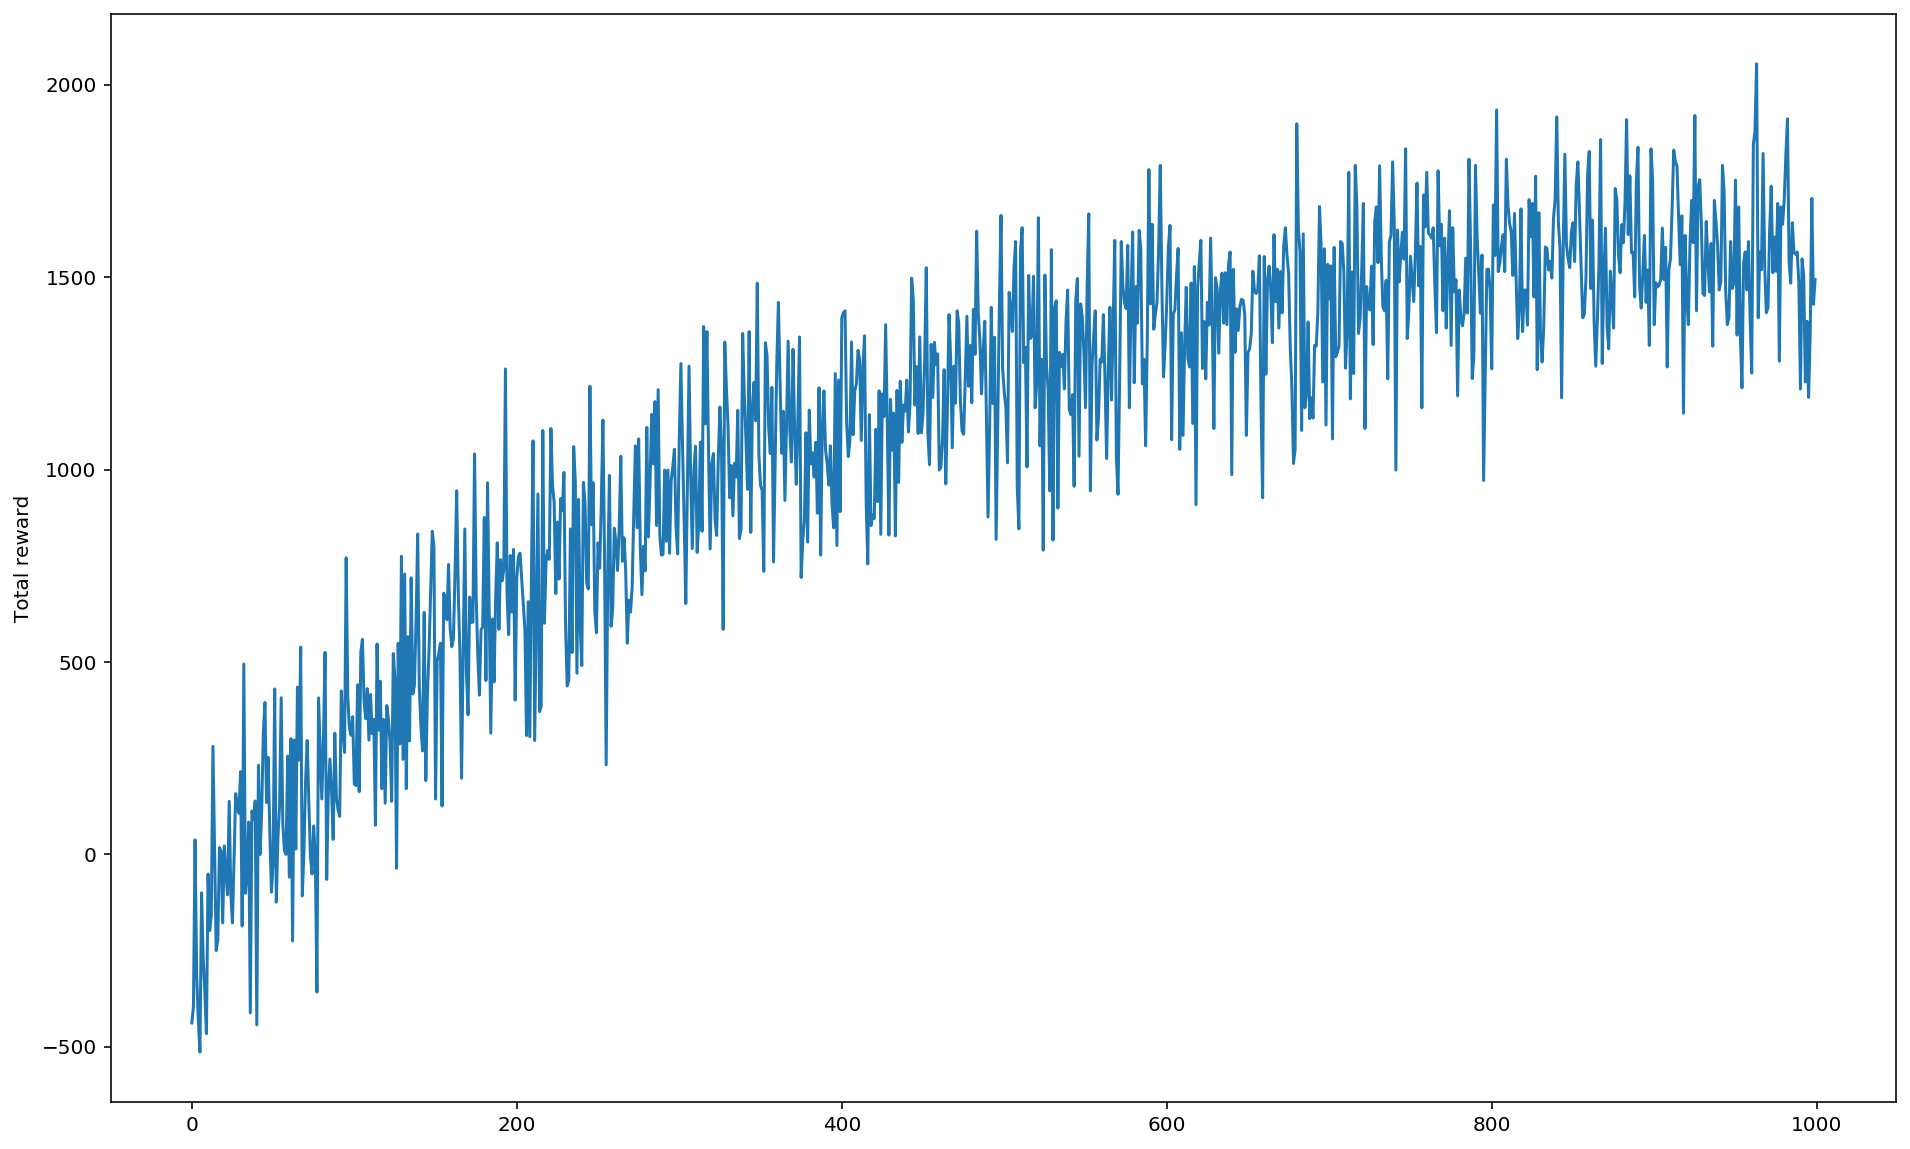

In [16]:
# Plotting total rewards
plt.figure(figsize=(16,10))
plt.plot(list(range(len(total_rewards))), total_rewards)
plt.ylabel("Total reward")
plt.show()

### Tracking Convergence

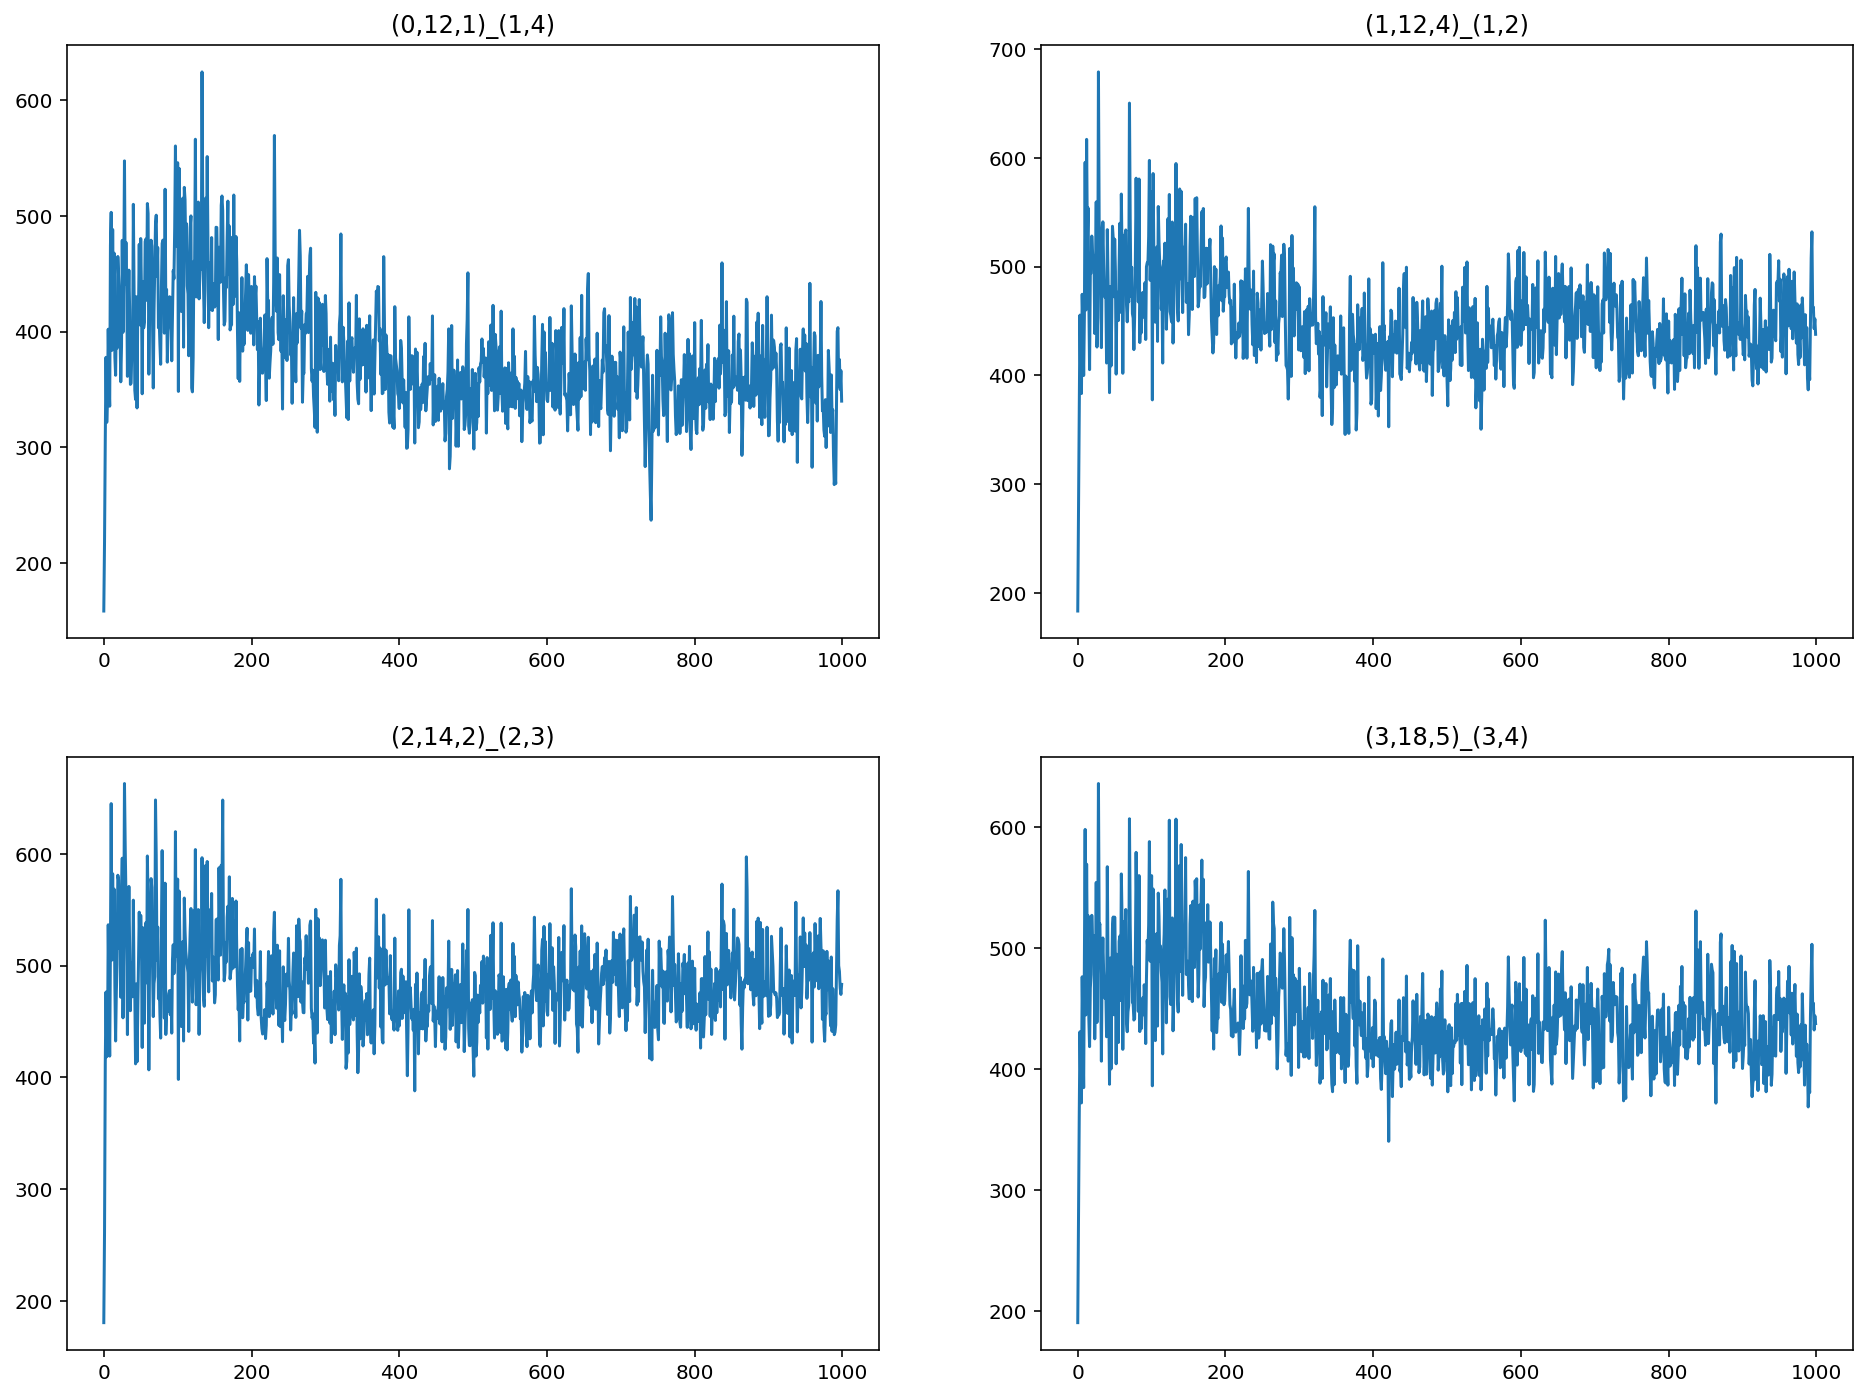

In [17]:
plot_tracked_values(agent.states_track)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [18]:
epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)

time = np.arange(0,Episodes)
epsilon = []
for i in range(0,Episodes):
    epsilon.append(epsilon_greedy_policy.get_epsilon(i))

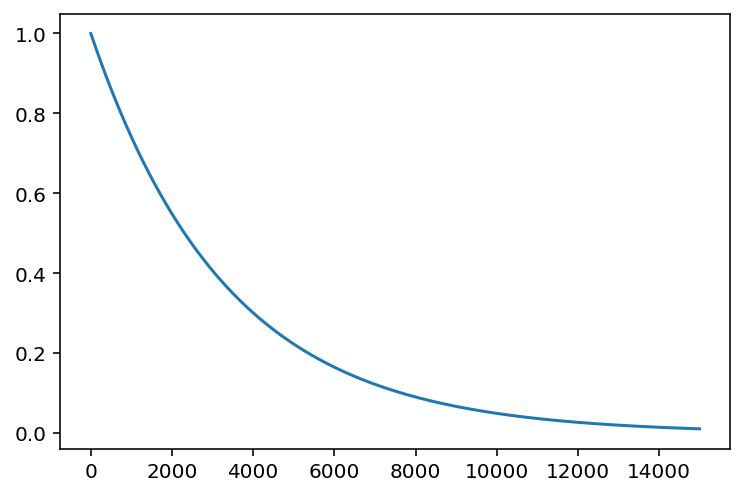

In [19]:
plt.plot(time, epsilon)
plt.show()